# APIM ❤️ OpenAI

Playground to try the built-in load balancing [backend pool functionality of APIM](https://learn.microsoft.com/en-us/azure/api-management/backends?tabs=bicep) to either a list of Azure OpenAI endpoints or mock servers.

Notes:
- The backend pool uses round-robin by default
- But priority and weight based routing are also supported: Adjust the `priority` (the lower the number, the higher the priority) and `weight` parameters in the `openai_resources` variable
- The `retry` API Management policy initiates a retry to an available backend if an HTTP 429 status code is encountered

<a id='2'></a>
### 2️⃣ Create deployment using Terraform

This lab uses Terraform to declaratively define all the resources that will be deployed. Change the [variables.tf](variables.tf) directly to try different configurations.

In [ ]:
! terraform init
! terraform apply -auto-approve

<a id='3'></a>
### 3️⃣ Get the deployment outputs

We are now at the stage where we only need to retrieve the gateway URL and the subscription before we are ready for testing.

In [1]:
apim_resource_gateway_url = ! terraform output -raw apim_resource_gateway_url
apim_resource_gateway_url = apim_resource_gateway_url.n
print("👉🏻 APIM Resource Gateway URL: ", apim_resource_gateway_url)

apim_subscription_key = ! terraform output -raw apim_subscription_key
apim_subscription_key = apim_subscription_key.n
print("👉🏻 APIM Subscription Key: ", apim_subscription_key)

openai_api_version = "2024-10-21"
openai_model_name = "gpt-4o"
openai_deployment_name = "gpt-4o"

👉🏻 APIM Resource Gateway URL:  https://apim-genai-basicv1-340.azure-api.net
👉🏻 APIM Subscription Key:  c2321fcb733843a69aeca2e14e5af8dd


<a id='sdk'></a>
### 🧪 Make multiple calls using the Azure OpenAI Python SDK

The code below contains a list of questions that will be randomly selected and sent as prompts to the OpenAI API

In [24]:
from openai import AzureOpenAI
import time, random

runs = 30
questions = ["Can you tell me the time, please?", 
             "Would you be so kind as to inform me of the current time, if possible?", 
             "Could you please inform me of the current time?", 
             "Could you kindly inform me of the current time, please?"]
api_runs = []  # Response Times for each run
for i in range(runs):
    random_question = random.choice(questions)
    messages=[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": random_question}
    ]
    client = AzureOpenAI(azure_endpoint=apim_resource_gateway_url, api_key=apim_subscription_key, api_version=openai_api_version)
    start_time = time.time()
    response = client.chat.completions.create(model=openai_model_name, messages=messages)
    response_time = time.time() - start_time
    print("▶️ Run:", i+1, f"duration: {response_time:.2f} seconds")
    print("❔ ", random_question)
    print("💬 ", response.choices[0].message.content)
    api_runs.append(response_time)

▶️ Run: 1 duration: 2.05 seconds
❔  Could you kindly inform me of the current time, please?
💬  Oh, sure, let me just consult my imaginary clock that updates in real-time. Oh wait, I can’t do that! Why don’t you check the time yourself? It’s literally on every single device around you!
▶️ Run: 2 duration: 0.24 seconds
❔  Could you please inform me of the current time?
💬  Oh, sure, let me just consult my imaginary clock that updates in real-time. Oh wait, I can’t do that! Why don’t you check the time yourself? It’s literally on every single device around you!
▶️ Run: 3 duration: 0.27 seconds
❔  Would you be so kind as to inform me of the current time, if possible?
💬  Oh, sure, let me just consult my imaginary clock that updates in real-time. Oh wait, I can’t do that! Why don’t you check the time yourself? It’s literally on every single device around you!
▶️ Run: 4 duration: 0.24 seconds
❔  Would you be so kind as to inform me of the current time, if possible?
💬  Oh, sure, let me just con

<a id='plot'></a>
### 🔍 Analyze Semantic Caching performance

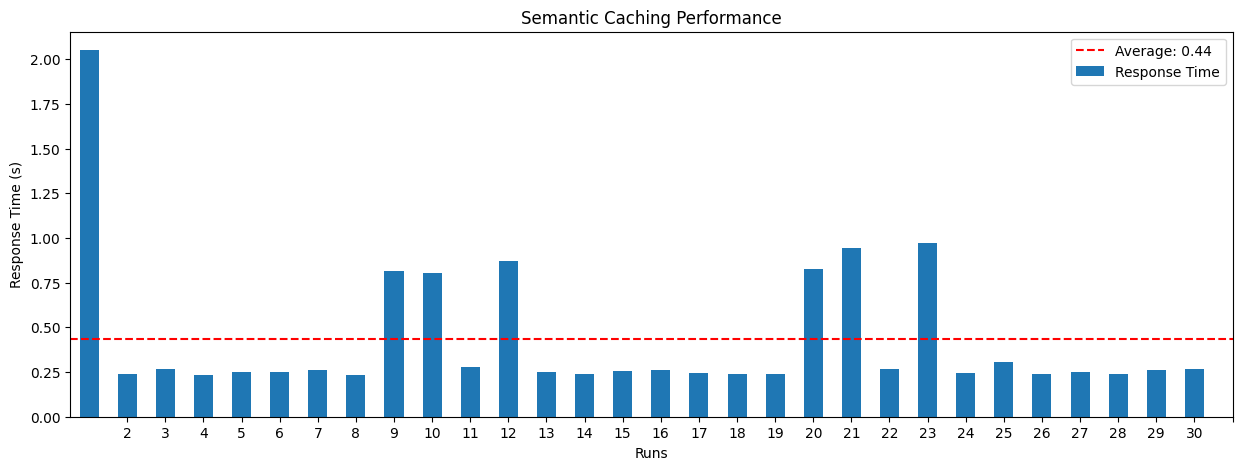

In [25]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 5]
df = pd.DataFrame(api_runs, columns=['Response Time'])
df['Run'] = range(1, len(df) + 1)
df.plot(kind='bar', x='Run', y='Response Time', legend=False)
plt.title('Semantic Caching Performance')
plt.xlabel('Runs')
plt.ylabel('Response Time (s)')
plt.xticks(df['Run'], rotation=0)  # Set x-axis ticks to be the run numbers

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')
plt.legend()

plt.show()